# Load Tensorflow and some essential python modules. 

In [0]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
plt.style.use('default')
import librosa
import pickle

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
!pwd

/content


# Load Training audio files

In [0]:
def read_value(file,flag=1):
    s, sr=librosa.load(file, sr=None, res_type='kaiser_fast')
    # Downsample to 8 KHz
    if flag == -5:
      s = librosa.resample(s, sr, 8000)
    X = librosa.stft(s, n_fft=1024, hop_length=512)
    X_ = np.abs(X)
    if flag == 1:
      # return absolute magnititude and frequency data
      return X_, X
    if flag == 0:
      # only return absolute magnititude
      return X_
    if flag == -1:
      # only return absolute magnititude in one dimensional vector
      return X_.reshape(-1)
    if flag == -2:
      # only retrun 2D absolute magnititude as two dimensional vector (513,20)
      # data either trimmed or padded to length size along the specified axis
      return librosa.util.fix_length(X_, 20, axis=1)
    if flag == -3:
      # only retrun 2D absolute magnititude as two dimensional vector (513,32)
      # data either trimmed or padded to length size along the specified axis
      return librosa.util.fix_length(X_, 32, axis=1)
    if flag == -4:
      # only retrun 2D complex magnititude as two dimensional vector (513,32)
      # data either trimmed or padded to length size along the specified axis
      return librosa.util.fix_length(X, 32, axis=1)
    if flag == -5:
      # only retrun 2D absolute magnititude as two dimensional vector (513,16)
      # data either trimmed or padded to length size along the specified axis
      return librosa.util.fix_length(X_, 16, axis=1)

Ref:
https://librosa.github.io/librosa/generated/librosa.core.resample.html

In [0]:
x_file = "./drive/My Drive/ENGR533/Final Project/Project/speech_commands_v0.01/bed/0a7c2a8d_nohash_0.wav"
test = read_value(x_file,flag=0)
print('raw absolute magnititude shape:', test.shape)
test = read_value(x_file,flag=-1)
print('reshape raw absolute magnititude as one dimensional vector:', test.shape)
test = read_value(x_file,flag=-2)
print('only retrun 2D absolute magnititude as two dimensional vector shape:', test.shape)

raw absolute magnititude shape: (513, 32)
reshape raw absolute magnititude as one dimensional vector: (16416,)
only retrun 2D absolute magnititude as two dimensional vector shape: (513, 20)


In [0]:
test = read_value(x_file,flag=-5)
test.shape

(513, 16)

In [0]:
temp = np.empty((1, 513, 16),dtype=complex)
temp[0] = test
temp[0]

array([[5.12491399e-03+0.j, 9.98343166e-05+0.j, 3.95671195e-05+0.j, ...,
        4.26910585e-04+0.j, 6.91248977e-04+0.j, 2.63384078e-04+0.j],
       [5.51866228e-03+0.j, 8.02878232e-04+0.j, 6.22904627e-04+0.j, ...,
        2.75809376e-04+0.j, 6.91604742e-04+0.j, 2.68432312e-04+0.j],
       [6.05890155e-03+0.j, 8.88471841e-04+0.j, 7.80837436e-04+0.j, ...,
        6.27591624e-04+0.j, 4.14798735e-04+0.j, 3.44572734e-04+0.j],
       ...,
       [1.78576878e-03+0.j, 5.41919326e-06+0.j, 5.55274084e-07+0.j, ...,
        1.22667589e-05+0.j, 1.00156858e-05+0.j, 8.74387933e-06+0.j],
       [1.78326666e-03+0.j, 3.06325751e-06+0.j, 2.07171706e-06+0.j, ...,
        2.11504266e-06+0.j, 4.10057419e-06+0.j, 5.43974011e-06+0.j],
       [1.78279495e-03+0.j, 1.83094286e-07+0.j, 1.98928092e-06+0.j, ...,
        2.57762053e-06+0.j, 4.63564993e-06+0.j, 2.28908084e-06+0.j]])

# Construct training data and training labels

load training data list

In [0]:
train_read = open('./drive/My Drive/ENGR533/Final Project/Project/speech_commands_v0.01/refine_training_list.txt','r')
train_list = [line[:-1] for line in train_read.readlines()]

Generating training labels and training data

Convert training data command to number, e.g., 'yes' --> '1' in a dictionary **label_dict**

In [0]:
classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown']

In [0]:
def load_2_label(file_path,classes):
  file_ = open(file_path,'r')
  list_ = [line[:-1] for line in file_.readlines()]
  l = len(list_)
  n_classes = len(classes)
  data_label = np.zeros((l,n_classes))
  for i in range(l):
    label = list_[i].split('/')[0]
    if label in classes[:-1]:
      index = classes.index(label)
      data_label[i][index] = 1
    else:
      data_label[i][-1] = 1
  return data_label

In [0]:
train_file = './drive/My Drive/ENGR533/Final Project/Project/speech_commands_v0.01/refine_training_list.txt'
train_label = load_2_label(train_file,classes)

Convert training data audio file in matrix **train_data**

In [0]:
train_data = np.load('./drive/My Drive/ENGR533/Final Project/Project/training_16_complex.npy')

In [0]:
print('training data shape', train_data.shape)
print('training label shape', train_label.shape)

training data shape (20391, 513, 16)
training label shape (20391, 11)


# Load validation and testing data files

**Load validation data**

In [0]:
valid_file = './drive/My Drive/ENGR533/Final Project/Project/speech_commands_v0.01/refine_validation_list.txt'
valid_label = load_2_label(valid_file,classes)
valid_data = np.load('./drive/My Drive/ENGR533/Final Project/Project/validation_16_complex.npy')

**Load testing data**

In [0]:
test_file = './drive/My Drive/ENGR533/Final Project/Project/speech_commands_v0.01/refine_testing_list.txt'
test_label = load_2_label(test_file,classes)
test_data = np.load('./drive/My Drive/ENGR533/Final Project/Project/testing_16_complex.npy')

In [0]:
print('validation data shape', valid_data.shape)
print('validation label shaope', valid_label.shape)
print('testing data shape', test_data.shape)
print('test label shaope', test_label.shape)

validation data shape (2834, 513, 16)
validation label shaope (2834, 11)
testing data shape (2823, 513, 16)
test label shaope (2823, 11)


# Exploratorty data analysis (EDA)

In [0]:
for j in range(11):
  counts = 0
  for i in range(len(train_label)):
    if train_label[i,j] == 1:
      counts += 1
  print('Number of files:',j+1,counts,counts/len(train_label))

Number of files: 1 1860 0.09121671325584817
Number of files: 2 1853 0.09087342455004659
Number of files: 3 1843 0.0903830121131872
Number of files: 4 1842 0.09033397086950125
Number of files: 5 1839 0.09018684713844344
Number of files: 6 1852 0.09082438330636065
Number of files: 7 1864 0.09141287823059192
Number of files: 8 1839 0.09018684713844344
Number of files: 9 1885 0.09244274434799667
Number of files: 10 1861 0.09126575449953411
Number of files: 11 1853 0.09087342455004659


In [0]:
from scipy.io import wavfile

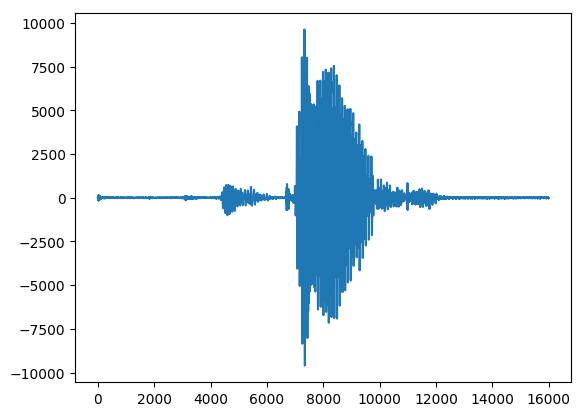

In [0]:
samplerate, test_sound = wavfile.read(x_file)
plt.plot(test_sound)

# Data augmentation

In [0]:
import pickle

In [0]:
with open('./drive/My Drive/ENGR533/Final Project/Project/Noise.pkl', 'rb') as f:
    Noise = pickle.load(f)

In [0]:
# Noise=[None]*1200
# for i in range(1200):
#   s, sr=librosa.load('./drive/My Drive/ENGR533/Final Project/noise/'+'trn'+'{0:04}'.format(i) + '.wav', sr=None)
#   Noise[i]=librosa.stft(s, n_fft=1024, hop_length=512)
#   print(i)

def addnoise(xbatch,flag = 0):
  # xbatch : (? , 513, 32)
    global Noise # Noise : (1200 , 513, ?)
  
    lengthx = np.shape(xbatch)[0]
    if flag == 0:
      for i in range(lengthx):
        rnd = np.random.randint(1200)
        lengthy = np.shape(Noise[rnd])[1]
        rnd2 = np.random.randint(lengthy-33)
        xbatch[i] = xbatch[i]+ 0.2*Noise[rnd][:,rnd2:rnd2+16]
      return np.abs(xbatch)
    else:
      return np.abs(xbatch)

In [0]:
train_data = addnoise(train_data,flag = 0)

In [0]:
valid_data = addnoise(valid_data,flag = 0)
test_data = addnoise(test_data,flag = 0)

In [0]:
del Noise

# Build baseline classifier: fully connected neural network

 **The neural network includes 5 hidden layers, each layer includes 1024 hidden units.**


General information about the input data size, the audio is 513 x 16 and number of classes is 11.

In [0]:
train_data = train_data.reshape(len(train_data),-1)
valid_data = valid_data.reshape(len(valid_data),-1)
test_data = test_data.reshape(len(test_data),-1)

In [0]:
size = 16416/2       # Number of elements 
n_classes = 11     # Number of classes

Define a few functions, including randomizing data before feed in mini batch optimization, and get batch functions to split training data

In [0]:
def randomize(x, y):
    """ Randomizes the order of data samples and their corresponding labels"""
    permutation = np.random.permutation(y.shape[0])
    shuffled_x = x[permutation, :]
    shuffled_y = y[permutation]
    return shuffled_x, shuffled_y

def get_next_batch(x, y, start, end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch

Initialize the hyper-parameters including the training epochs and hidden units

In [0]:
# Hyper-parameters
epochs = 15             # Total number of training epochs
batch_size = 100        # Training batch size
display_freq = 100      # Frequency of displaying the training results
learning_rate = 0.001   # The optimization initial learning rate

h1 = 1024               # number of nodes in the 1st hidden layer
h2 = 1024               # number of nodes in the 2nd hidden layer
h3 = 1024               # number of nodes in the 3rd hidden layer
h4 = 1024               # number of nodes in the 4th hidden layer
h5 = 1024               # number of nodes in the 5th hidden layer

Create weight and bias variables

In [0]:
# Creat Weights and Bias
def weight_variable(name, shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W_' + name,
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)

def bias_variable(name, shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b_' + name,
                           dtype=tf.float32,
                           initializer=initial)

Creat a layer function  and use Rectified Linear Units (ReLU) as activation function. <br>
$ L = W*X+b $

In [0]:
# Create a layer
def fc_layer(x, num_units, name, use_relu=True):
    """
    Create a fully-connected layer
    :param x: input from previous layer
    :param num_units: number of hidden units in the fully-connected layer
    :param name: layer name
    :param use_relu: boolean to add ReLU non-linearity (or not)
    :return: The output array
    """
    in_dim = x.get_shape()[1]
    W = weight_variable(name, shape=[in_dim, num_units])
    b = bias_variable(name, [num_units])
    layer = tf.matmul(x, W)
    layer += b
    if use_relu:
        layer = tf.nn.relu(layer)
    return b,W,layer

Set a reset graph in case there is running error, when multi graph is created because of running code back and forth.

In [0]:
tf.reset_default_graph()

Create the graph for the linear model. Placeholders for inputs (x,image) and outputs(y,label) 

In [0]:
x = tf.placeholder(tf.float32, shape=[None, size], name='X')
y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')

Create a fully-connected layers with 1024 units of 5 hidden layer. <br>
Then create a fully-connected layer with n_classes nodes as output layer. 

In [0]:
b1, w1, fc1 = fc_layer(x, h1, 'FC1', use_relu=True)
b2, w2, fc2 = fc_layer(fc1, h2, 'FC2',use_relu=True)
b3, w3, fc3 = fc_layer(fc2, h3, 'FC3', use_relu=True)
b4, w4, fc4 = fc_layer(fc3, h4, 'FC4', use_relu=True)
b5, w5, fc5 = fc_layer(fc4, h5, 'FC5', use_relu=True)
b6, w6, output_logits = fc_layer(fc5, n_classes, 'OUT', use_relu=False)

Instructions for updating:
Colocations handled automatically by placer.


Define the loss function using the output labels and true labels, calculate the loss using the softmax function. <br>
Define optimization function the using the AdamOptimizer. <br>
Define accuracy function by calculating the number of correct predictions.



In [0]:
# Define the loss function, optimizer, and accuracy
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam-op').minimize(loss)
correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

# Network predictions
cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
# Create the init for initializing all variables
init = tf.global_variables_initializer()

In [0]:
# Create an interactive session (to keep the session in the other cells)
sess = tf.InteractiveSession()
# Initialize all variables
sess.run(init)
saver = tf.train.Saver()

The main training session starts here.

In [0]:
# Number of training iterations in each epoch
num_tr_iter = int(len(train_label) / batch_size)
train_acc_all = []
valid_acc_all = []
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch + 1))
    # Randomly shuffle the training data at the beginning of each epoch 
    x_train, y_train = randomize(train_data, train_label)
    for iteration in range(num_tr_iter):
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        x_batch, y_batch = get_next_batch(x_train, y_train, start, end)

        # Run optimization op (backprop)
        feed_dict_batch = {x: x_batch, y: y_batch}
        sess.run(optimizer, feed_dict=feed_dict_batch)

        if iteration % display_freq == 0:
            # Calculate and display the batch loss and accuracy
            loss_batch, acc_batch = sess.run([loss, accuracy],
                                             feed_dict=feed_dict_batch)

            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                  format(iteration, loss_batch, acc_batch))
            train_acc_all.append(acc_batch)
    # Run validation after every epoch
    feed_dict_valid = {x: valid_data, y: valid_label}
    loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict=feed_dict_valid)
    valid_acc_all.append(acc_valid)
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
          format(epoch + 1, loss_valid, acc_valid))
    print('---------------------------------------------------------')
    

Training epoch: 1
iter   0:	 Loss=2.39,	Training Accuracy=16.0%
iter 100:	 Loss=2.22,	Training Accuracy=18.0%
iter 200:	 Loss=1.73,	Training Accuracy=39.0%
---------------------------------------------------------
Epoch: 1, validation loss: 1.86, validation accuracy: 29.4%
---------------------------------------------------------
Training epoch: 2
iter   0:	 Loss=1.77,	Training Accuracy=28.0%
iter 100:	 Loss=1.49,	Training Accuracy=47.0%
iter 200:	 Loss=1.21,	Training Accuracy=53.0%
---------------------------------------------------------
Epoch: 2, validation loss: 1.49, validation accuracy: 45.9%
---------------------------------------------------------
Training epoch: 3
iter   0:	 Loss=1.04,	Training Accuracy=64.0%
iter 100:	 Loss=0.86,	Training Accuracy=73.0%
iter 200:	 Loss=0.97,	Training Accuracy=67.0%
---------------------------------------------------------
Epoch: 3, validation loss: 1.28, validation accuracy: 58.0%
---------------------------------------------------------
Trai

In [0]:
def plot_accuracy(train,valid):
  plt.plot(train,'g',label='training data')
  plt.plot(valid,'r',label='validation data')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend(loc='lower right')
  plt.title('Improvement of prediction accuracy with increasing epoch')
  return 

In [0]:
train_acc = []
for i in range(0,len(train_acc_all)-3,3):
  pts = np.mean(train_acc_all[i:i+3])
  train_acc.append(pts)
plot_accuracy(train_acc,valid_acc_all)

**Save the model**

In [0]:
saver.save(sess, './drive/My Drive/FCNN-model-noise')

'./drive/My Drive/FCNN-model-noise'

Test prediction accuracy on test set. 

In [0]:
# Test the network after training
# Accuracy
feed_dict_test = {x: test_data, y: test_label}
loss_test, acc_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)

print('---------------------------------------------------------')
print("Test loss: {0:.2f}, test accuracy: {1:.01%}".format(loss_test, acc_test))
print('---------------------------------------------------------')

---------------------------------------------------------
Test loss: 1.53, test accuracy: 69.7%
---------------------------------------------------------


**The fully connected neural network baseline model achives 75.3% accuracy on test data set.**

In [0]:
sess.close()

In [0]:
del train_data
del valid_data
del test_data

In [0]:
del x_train
del y_train

# Build LSTM, CNN model for the training dataset

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout,SpatialDropout1D, Reshape
from keras.preprocessing import sequence
from keras.models import model_from_json
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import CSVLogger
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [0]:
# Training parameters.
batch_size = 32
num_classes = 11
epochs = 15

In [0]:
train_data = train_data.reshape(train_data.shape[0],train_data.shape[1],train_data.shape[2],1)
train_data.shape

(20391, 513, 16, 1)

In [0]:
valid_data = valid_data.reshape(valid_data.shape[0],valid_data.shape[1],valid_data.shape[2],1)
valid_data.shape
test_data = test_data.reshape(test_data.shape[0],test_data.shape[1],test_data.shape[2],1)
test_data.shape

(2823, 513, 16, 1)

## CNN model

In [0]:
cnn_model = Sequential()
cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(513, 16, 1)))
cnn_model.add(MaxPooling2D(pool_size=(3, 3)))
cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(num_classes, activation='softmax'))
cnn_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
csv_logger = CSVLogger('cnn_log-16-noise.csv', append=True, separator=';')

In [0]:
for epoch in range(epochs):
  cnn_model.fit(train_data, train_label,
            batch_size=batch_size,
            epochs=epoch+1,
            initial_epoch=epoch,
            verbose=1,
            validation_data=(valid_data, valid_label),
            callbacks=[csv_logger])

Instructions for updating:
Use tf.cast instead.
Train on 20391 samples, validate on 2834 samples
Epoch 1/1
20391/20391 [==============================] - 20s 985us/step - loss: 1.9376 - acc: 0.3499 - val_loss: 1.6353 - val_acc: 0.4757
Train on 20391 samples, validate on 2834 samples
Epoch 2/2
20391/20391 [==============================] - 18s 867us/step - loss: 1.5055 - acc: 0.5006 - val_loss: 1.4670 - val_acc: 0.5427
Train on 20391 samples, validate on 2834 samples
Epoch 3/3
20391/20391 [==============================] - 18s 880us/step - loss: 1.2985 - acc: 0.5762 - val_loss: 1.3568 - val_acc: 0.5840
Train on 20391 samples, validate on 2834 samples
Epoch 4/4
20391/20391 [==============================] - 18s 882us/step - loss: 1.1347 - acc: 0.6247 - val_loss: 1.3077 - val_acc: 0.5967
Train on 20391 samples, validate on 2834 samples
Epoch 5/5
20391/20391 [==============================] - 18s 882us/step - loss: 1.0177 - acc: 0.6645 - val_loss: 1.3326 - val_acc: 0.6041
Train on 20391 sa

In [0]:
import pandas as pd

In [0]:
cnn_hist = pd.read_csv('cnn_log-16-noise.csv',sep=';')
cnn_hist.columns

Index(['epoch', 'acc', 'loss', 'val_acc', 'val_loss'], dtype='object')

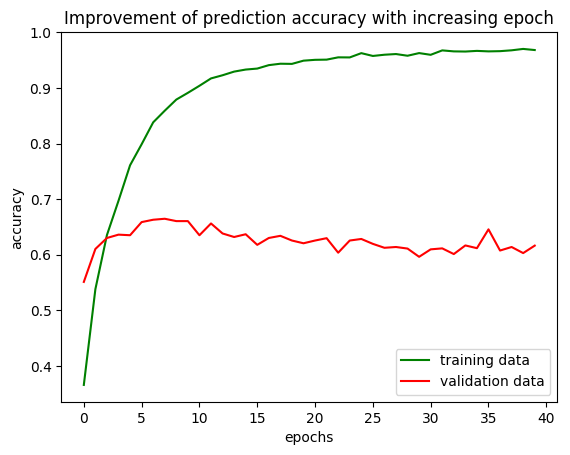

In [0]:
plot_accuracy(cnn_hist.acc,cnn_hist.val_acc)

In [0]:
# Evaluation.
scores = cnn_model.evaluate(test_data, test_label, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 1.813769690837583
Test accuracy: 0.6167198016453076


**Save keras model**

In [0]:
# serialize model to JSON
model_json = cnn_model.to_json()
with open("./drive/My Drive/cnn_model_32.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn_model.save_weights("./drive/My Drive/cnn_model_32.h5")
print("Saved model to disk")

Saved model to disk


**Load keras model**

In [0]:
# load json and create model
json_file = open('./drive/My Drive/cnn_model_32.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./drive/My Drive/cnn_model_32.h5")
print("Loaded model from disk")

In [0]:
train_data = train_data.reshape(train_data.shape[0],train_data.shape[1],train_data.shape[2])

In [0]:
valid_data = valid_data.reshape(valid_data.shape[0],valid_data.shape[1],valid_data.shape[2])
test_data = test_data.reshape(test_data.shape[0],test_data.shape[1],test_data.shape[2])

## LSTM model

Transpose input model

In [0]:
model = Sequential()
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model.summary()

In [0]:
train_data_lstm = np.transpose(train_data, (0, 2, 1))
valid_data_lstm = np.transpose(valid_data,(0, 2, 1))
test_data_lstm = np.transpose(test_data,(0, 2, 1))

In [0]:
train_data_lstm.shape

(20391, 16, 513)

In [0]:
valid_data_lstm.shape

(2834, 16, 513)

In [0]:
test_data_lstm.shape

(2823, 16, 513)

In [0]:
csv_logger = CSVLogger('lstm_log-16-noise.csv', append=True, separator=';')

In [0]:
for epoch in range(epochs):
  model.fit(train_data_lstm, train_label,
            batch_size=batch_size,
            epochs=epoch+1,
            initial_epoch=epoch,
            verbose=1,
            validation_data=(valid_data_lstm, valid_label),
            callbacks=[csv_logger])

Train on 20391 samples, validate on 2834 samples
Epoch 1/1
20391/20391 [==============================] - 34s 2ms/step - loss: 1.4853 - acc: 0.4815 - val_loss: 0.8995 - val_acc: 0.7043
Train on 20391 samples, validate on 2834 samples
Epoch 2/2
20391/20391 [==============================] - 33s 2ms/step - loss: 0.8967 - acc: 0.6939 - val_loss: 0.7187 - val_acc: 0.7505
Train on 20391 samples, validate on 2834 samples
Epoch 3/3
20391/20391 [==============================] - 34s 2ms/step - loss: 0.7250 - acc: 0.7515 - val_loss: 0.6387 - val_acc: 0.7802
Train on 20391 samples, validate on 2834 samples
Epoch 4/4
20391/20391 [==============================] - 35s 2ms/step - loss: 0.6301 - acc: 0.7832 - val_loss: 0.6195 - val_acc: 0.7876
Train on 20391 samples, validate on 2834 samples
Epoch 5/5
20391/20391 [==============================] - 35s 2ms/step - loss: 0.5686 - acc: 0.8065 - val_loss: 0.5859 - val_acc: 0.7957
Train on 20391 samples, validate on 2834 samples
Epoch 6/6
20391/20391 [===

In [0]:
lstm_hist = pd.read_csv('lstm_log-16-noise.csv',sep=';')
lstm_hist.columns

Index(['epoch', 'acc', 'loss', 'val_acc', 'val_loss'], dtype='object')

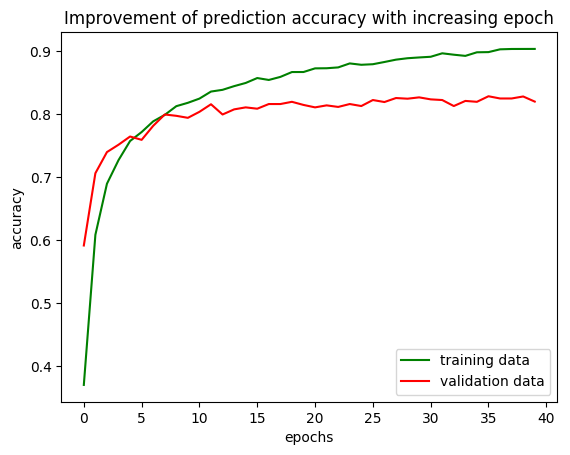

In [0]:
plot_accuracy(lstm_hist.acc,lstm_hist.val_acc)

**Evaluate model on test data set**

In [0]:
# Evaluation.
scores = model.evaluate(test_data_lstm, test_label, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.5687926592152887
Test accuracy: 0.825008855890476


**Save keras model**

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("./drive/My Drive/lstm_model_32.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./drive/My Drive/lstm_model_32.h5")
print("Saved model to disk")

Saved model to disk


**Load keras model**

In [0]:
# load json and create model
json_file = open('./drive/My Drive/lstm_model_32.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./drive/My Drive/lstm_model_32.h5")
print("Loaded model from disk")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk


In [0]:
test_data_lstm_pred = loaded_model.predict(test_data_lstm)

In [0]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(test_data_lstm, test_label, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

acc: 89.13%


In [0]:
matrix = confusion_matrix(test_label.argmax(axis=1), test_data_lstm_pred.argmax(axis=1))

In [0]:
matrix

array([[229,   0,   0,   0,  11,   1,   0,   2,   0,   0,  13],
       [  1, 231,   6,   2,   1,   2,   0,   1,   1,   3,   4],
       [  0,   1, 260,   0,   2,   1,   2,   4,   0,   2,   0],
       [  0,  14,   2, 216,   0,   1,   4,   1,   0,   8,   7],
       [  6,   3,   5,   0, 247,   3,   0,   0,   0,   0,   3],
       [  0,   0,   3,   2,   2, 232,   2,   0,   0,   1,  17],
       [  0,   0,   4,   1,   3,   0, 233,   1,   1,   0,   3],
       [  1,   1,  10,   0,   2,   0,   5, 237,   1,   1,   4],
       [  0,   1,   4,   2,   1,   0,   0,   3, 236,   0,   2],
       [  1,  23,   6,   5,   3,   0,   1,   1,   3, 208,   0],
       [  1,   2,   3,   9,   4,  20,   8,   2,   6,  14, 187]])

In [0]:
classes

['yes',
 'no',
 'up',
 'down',
 'left',
 'right',
 'on',
 'off',
 'stop',
 'go',
 'unknown']

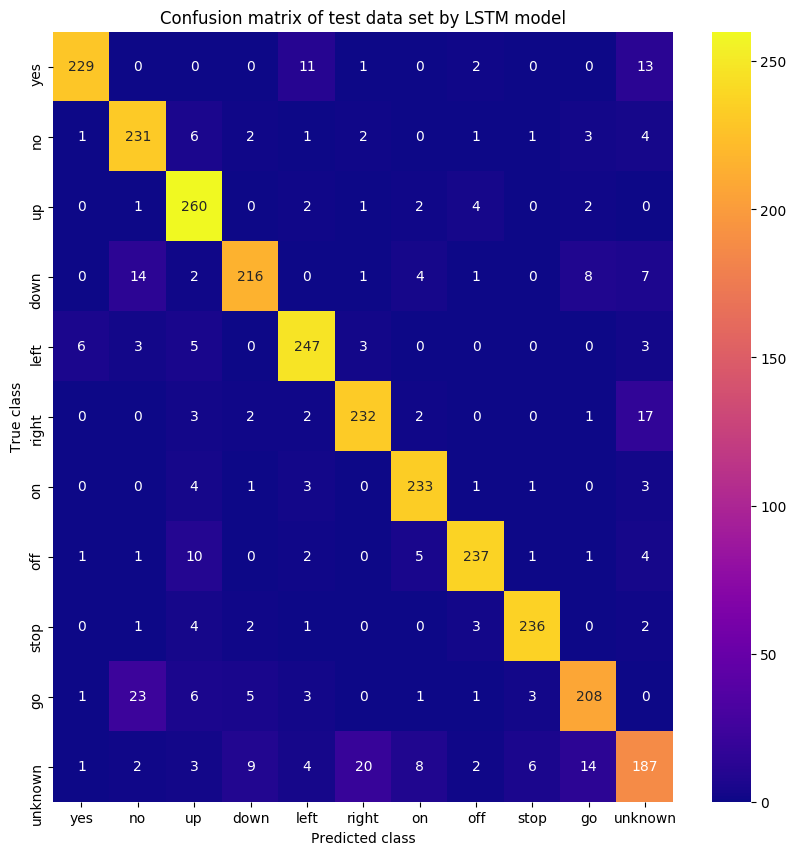

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt     
plt.figure(figsize=(10,10))
ax= plt.subplot()
sns.heatmap(matrix, fmt="d", annot=True, ax = ax, cmap="plasma"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted class');ax.set_ylabel('True class'); 
ax.set_title('Confusion matrix of test data set by LSTM model'); 
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);